In [1]:
!pip install qutip

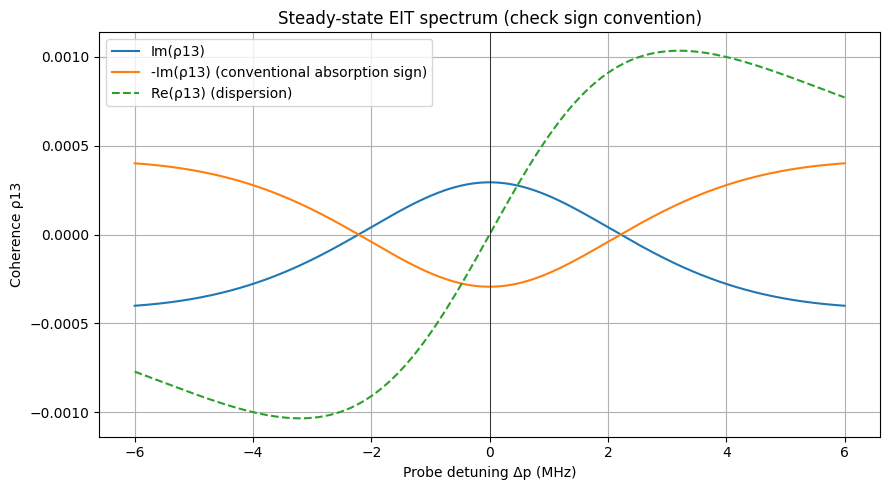

C:\Users\Siddharth\anaconda3\Lib\site-packages\qutip\solver\solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


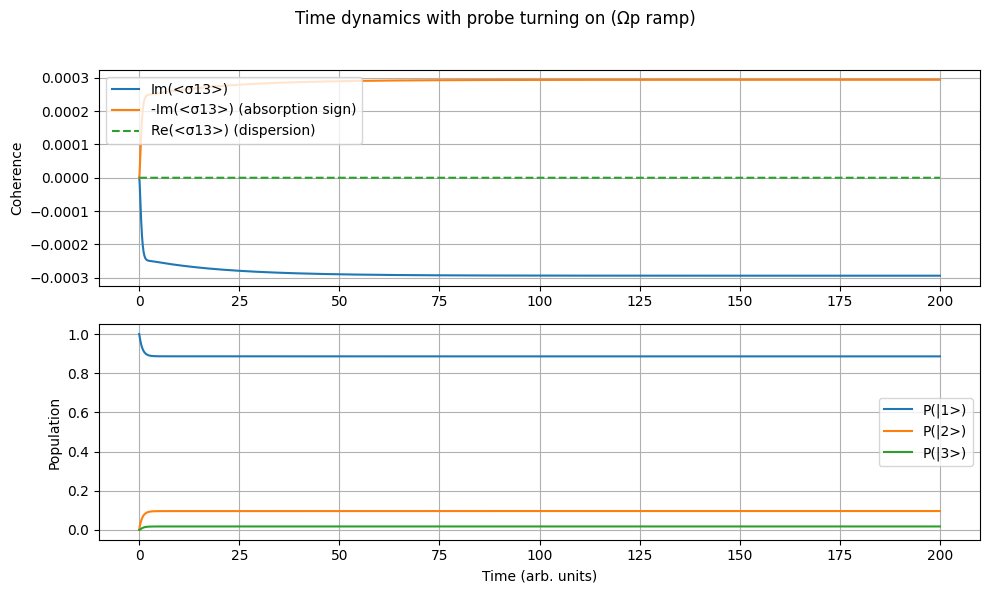

Final Im(ρ13) from mesolve (last time): -0.00029367478707683573
Steady-state Im(ρ13) from steadystate(): 0.0002936770708059114
Use -Im(ρ13) as absorption if steadystate shows dip in -Im and peak in Im.


In [21]:
# EIT: steady-state + time-dependent (mesolve) with full decay & dephasing
# Requires: qutip, numpy, matplotlib

import numpy as np
import matplotlib.pyplot as plt
from qutip import *


# PARAMETERS (tweak if needed)

Ωp = 0.02 * 2 * np.pi       # probe Rabi frequency (weak)
Ωc = 1.0  * 2 * np.pi       # control Rabi frequency (strong)
Δc = 0.0 * 2 * np.pi        # control detuning

# detuning sweep for steady-state
Δp_array = np.linspace(-6, 6, 401) * 2 * np.pi

# decay / dephasing (all in angular freq units)
γ13 = 1.0 * 2 * np.pi       # |3> -> |1>
γ23 = 1.0 * 2 * np.pi       # |3> -> |2>
γ21 = 0.02 * 2 * np.pi      # |2> -> |1>
γ12_deph = 0.01 * 2 * np.pi # ground-state dephasing
γ33_deph = 0.2  * 2 * np.pi # excited-state pure dephasing


# BASIS & OPERATORS

g1 = basis(3,0)   # |1>
g2 = basis(3,1)   # |2>
e  = basis(3,2)   # |3>

σ13 = g1 * e.dag()   # |1><3|
σ31 = σ13.dag()
σ23 = g2 * e.dag()   # |2><3|
σ32 = σ23.dag()
σ12 = g1 * g2.dag()  # |1><2|
σ21 = σ12.dag()
σ33 = e * e.dag()


# COLLAPSE OPERATORS

c_ops = []
c_ops.append(np.sqrt(γ13) * σ13)     # |3> -> |1>
c_ops.append(np.sqrt(γ23) * σ23)     # |3> -> |2>
c_ops.append(np.sqrt(γ21) * σ21)     # |2> -> |1>
# Dephasing: ground and excited
# ground-state dephasing can be implemented as dephasing on levels |1>, |2> or via σ12†σ12
# a common approach: apply dephasing operator for |1> and |2> populations differences.
c_ops.append(np.sqrt(γ12_deph) * (σ33*0 + (g1*g1.dag() - g2*g2.dag()))) # alternative ground dephasing
c_ops.append(np.sqrt(γ33_deph) * σ33)  # excited-state pure dephasing

# Note: QuTiP allows multiple forms; above ground dephasing operator is a simple model
# If you prefer the σ12†σ12 form used earlier, replace accordingly.


# STEADY-STATE SWEEP

abs_list = []        # Im(ρ13)
minus_abs_list = []  # -Im(ρ13)
disp_list = []       # Re(ρ13)

for dp in Δp_array:
    # Hamiltonian (in rotating frame, RWA)
    H = (-dp) * σ33 + (-Δc) * (g2 * g2.dag()) \
        + 0.5 * (Ωp * (σ13 + σ31) + Ωc * (σ23 + σ32))

    rho_ss = steadystate(H, c_ops)
    rho13 = rho_ss[0,2]
    abs_list.append(np.imag(rho13))
    minus_abs_list.append(-np.imag(rho13))
    disp_list.append(np.real(rho13))

# Plot steady-state results
plt.figure(figsize=(9,5))
plt.plot(Δp_array/(2*np.pi), abs_list, label='Im(ρ13)')
plt.plot(Δp_array/(2*np.pi), minus_abs_list, label='-Im(ρ13) (conventional absorption sign)')
plt.plot(Δp_array/(2*np.pi), disp_list, '--', label='Re(ρ13) (dispersion)')
plt.axvline(0, color='k', linewidth=0.5)
plt.xlabel('Probe detuning Δp (MHz)')
plt.ylabel('Coherence ρ13')
plt.title('Steady-state EIT spectrum (check sign convention)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# If you see a peak in Im(ρ13) and a dip in -Im(ρ13), use -Im(ρ13) as absorption.


# TIME-DEPENDENT (mesolve) TO WATCH DYNAMICS

# We'll choose one detuning (resonance dp=0) and another off-resonance to compare
dp_on = 0.0 * 2 * np.pi
dp_off = 2.5 * 2 * np.pi

# Build H0 (time-independent part) and H_probe(t)
H0 = (-dp_on) * σ33 + (-Δc) * (g2 * g2.dag()) + 0.5 * Ωc * (σ23 + σ32)

# time-dependent probe envelope: turn on slowly (adiabatic ramp)
tlist = np.linspace(0, 200, 2001)  # adjust timescale so dynamics settle
tau = 20.0                         # ramp timescale

def Ωp_t(t, args):
    # smooth turn-on from 0 to Ωp
    return Ωp * (1 - np.exp(-t/tau))

# time-dependent Hamiltonian: H = H0 + 0.5*Ωp(t)*(σ13 + σ31) + small dp term if dp not zero
H_td = [H0, [0.5*(σ13 + σ31), Ωp_t]]

# initial state: all population in |1>
rho0 = g1 * g1.dag()

# Observables: coherence and populations
ops = [σ13, σ13.dag(), g1*g1.dag(), g2*g2.dag(), σ33]

# Run mesolve
result = mesolve(H_td, rho0, tlist, c_ops, ops, args={})

# Extract results
rho13_t = result.expect[0]         # <σ13>
rho31_t = result.expect[1]         # <σ31>
pop1 = result.expect[2]
pop2 = result.expect[3]
pop3 = result.expect[4]

# Plot time dynamics
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(tlist, np.imag(rho13_t), label='Im(<σ13>)')
plt.plot(tlist, -np.imag(rho13_t), label='-Im(<σ13>) (absorption sign)')
plt.plot(tlist, np.real(rho13_t), '--', label='Re(<σ13>) (dispersion)')
plt.ylabel('Coherence')
plt.legend()
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(tlist, pop1, label='P(|1>)')
plt.plot(tlist, pop2, label='P(|2>)')
plt.plot(tlist, pop3, label='P(|3>)')
plt.xlabel('Time (arb. units)')
plt.ylabel('Population')
plt.legend()
plt.grid(True)

plt.suptitle('Time dynamics with probe turning on (Ωp ramp)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Compare final mesolve steady state with steadystate solver at dp_on
# Build H for dp_on and compute steadystate
H_on = (-dp_on) * σ33 + (-Δc) * (g2 * g2.dag()) + 0.5 * (Ωp * (σ13 + σ31) + Ωc * (σ23 + σ32))
rho_ss_on = steadystate(H_on, c_ops)
print("Final Im(ρ13) from mesolve (last time):", np.imag(rho13_t[-1]))
print("Steady-state Im(ρ13) from steadystate():", np.imag(rho_ss_on[0,2]))
print("Use -Im(ρ13) as absorption if steadystate shows dip in -Im and peak in Im.")

# Optionally: run mesolve for off-resonance dp_off by updating H0 and rerunning


In [2]:
!pwd

/c/Users/Siddharth


In [4]:
!git status

fatal: not a git repository (or any of the parent directories): .git
